<a href="https://colab.research.google.com/github/bacnc1/Medical-Image-Analysis/blob/main/Atrium_Segmentation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install gdown if not installed already
!pip install gdown

# Download the file using its file ID
file_id = '1wEB2I6S6tQBVEPxir8cA5kFB8gTQadYY'
gdown_url = f'https://drive.google.com/uc?id={file_id}'
!gdown {gdown_url}


Downloading...
From (original): https://drive.google.com/uc?id=1wEB2I6S6tQBVEPxir8cA5kFB8gTQadYY
From (redirected): https://drive.google.com/uc?id=1wEB2I6S6tQBVEPxir8cA5kFB8gTQadYY&confirm=t&uuid=cf4eac2b-8645-4bed-9c09-818f79d98304
To: /content/Task02_Heart.tar
100% 456M/456M [00:11<00:00, 38.1MB/s]


In [2]:
# Giải nén file .tar
!tar -xf /content/Task02_Heart.tar -C /content/


In [3]:
%matplotlib notebook
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [4]:
root = Path("/content/Task02_Heart/imagesTr")
label = Path("/content/Task02_Heart/labelsTr")

In [5]:
def change_img_to_label_path(path):
    """
    Replaces imagesTr with labelsTr
    """
    parts = list(path.parts)  # get all directories within the path
    parts[parts.index("imagesTr")] = "labelsTr"  # Replace imagesTr with labelsTr
    return Path(*parts)  # Combine list back into a Path object


In [6]:
sample_path = list(root.glob("la*"))[0]  # Choose a subject
sample_path_label = change_img_to_label_path(sample_path)

In [7]:
sample_path, sample_path_label

(PosixPath('/content/Task02_Heart/imagesTr/la_029.nii.gz'),
 PosixPath('/content/Task02_Heart/labelsTr/la_029.nii.gz'))

In [8]:
data = nib.load(sample_path)
label = nib.load(sample_path_label)

mri = data.get_fdata()
mask = label.get_fdata().astype(np.uint8)  # Class labels should not be handled as float64

In [9]:
nib.aff2axcodes(data.affine)

('R', 'A', 'S')

In [10]:
!pip install celluloid

Let's inspect the data. We use the sagittal view for this task as it provides the "nicest" images

We can use celluloid (https://github.com/jwkvam/celluloid) which is a great tool for live visualization in matplotlib.
Additionally we import HTML from IPython.display to create a video of the volume.

In [12]:
fig = plt.figure()
camera = Camera(fig)  # Create the camera object from celluloid

for i in range(mri.shape[2]):  # Sagital view
    plt.imshow(mri[:,:,i], cmap="bone")
    mask_ = np.ma.masked_where(mask[:,:,i]==0, mask[:,:,i])
    plt.imshow(mask_, alpha=0.5, cmap="autumn")
    # plt.axis("off")
    camera.snap()  # Store the current slice
animation = camera.animate()  # Create the animation




<IPython.core.display.Javascript object>

In [13]:
HTML(animation.to_html5_video())  # convert the animation to a video


## Preprocessing
We perform the following preprocessing steps:

1. Normalization per subject. We compute mean and sigma of the full 3d volume $X$ and then perform z-normalization:
$$X_n = \frac{X-\mu}{\sigma}$$
2. There is a plenty of empty space around the image, so we can crop the image (e.g 32 px from top and bottom). Additionally, we can crop away non-cardiac regions as they will definitely not contain the left atrium. This will  reduce training time due to the smaller size and will simplify the segmentation. It is important to crop first and to normalize afterwards. Otherwise the included zero values introduce skewness to the intesity distribution.
3. Standardize the normalized subject into the 0-1 range:
$$X_s = \frac{X_n - min(X_n)}{max(X_n)-min(X_n)} $$
4. This task will be performed on a slice level (2D) and not on a subject level (3D). In order to reduce the computational cost we store the preprocessed data as npy files of 2d slices. Reading a single slice is much faster than loading the complete NIfTI file every time.

In [14]:
# Helper functions for normalization and standardization
def normalize(full_volume):
    """
    Z-Normalization of the whole subject
    """
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std
    return normalized

def standardize(normalized_data):
    """
    Standardize the normalized data into the 0-1 range
    """
    standardized_data = (normalized_data - normalized_data.min()) / (normalized_data.max() - normalized_data.min())
    return standardized_data


In [15]:
def normalize(full_volume):
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std
    return normalized

def standardize(normalized):
    standardized = (normalized - normalized.min()) / (normalized.max() - normalized.min())
    return standardized


Now we can loop over the subjects and store the preprocessed files in the corresponding directories.
To evaluate our model we use the last 4 subjects as validation set.

We want to create a directory containing a numpy file for each slice of the MRI image and the associated label mask of each subject.
E.g:
* 0/data/0.npy
* 0/masks/0.npy

In [16]:
all_files = list(root.glob("la*"))  # Get all subjects
len(all_files)

20

In [17]:
save_root = Path("Preprocessed")

for counter, path_to_mri_data in enumerate(tqdm(all_files)):

    path_to_label = change_img_to_label_path(path_to_mri_data)

    mri = nib.load(path_to_mri_data)
    assert nib.aff2axcodes(mri.affine) == ("R", "A", "S")
    mri_data = mri.get_fdata()
    label_data = nib.load(path_to_label).get_fdata().astype(np.uint8)

    # Crop volume and label mask. Reduce 32 px from top and 32 px from bottom.
    # Addtionally crop front and back with same size. Dont crop viewing axis
    mri_data = mri_data[32:-32, 32:-32]
    label_data = label_data[32:-32, 32:-32]

    # Normalize and standardize the images
    normalized_mri_data = normalize(mri_data)
    standardized_mri_data = standardize(normalized_mri_data)

    # Check if train or val data and create corresponding path
    if counter < 17:
        current_path = save_root/"train"/str(counter)
    else:
        current_path = save_root/"val"/str(counter)

    # Loop over the slices in the full volume and store the images and labels in the data/masks directory
    for i in range(standardized_mri_data.shape[-1]):
        slice = standardized_mri_data[:,:,i]
        mask = label_data[:,:,i]
        slice_path = current_path/"data"
        mask_path = current_path/"masks"
        slice_path.mkdir(parents=True, exist_ok=True)
        mask_path.mkdir(parents=True, exist_ok=True)

        np.save(slice_path/str(i), slice)
        np.save(mask_path/str(i), mask)




  0%|          | 0/20 [00:00<?, ?it/s]

In [18]:
path = Path("Preprocessed/train/0")  # Select a subject


In [19]:
# Choose a file and load slice + mask
file = "50.npy"
slice = np.load(path/"data"/file)
mask = np.load(path/"masks"/file)

In [20]:
# Plot everything
plt.figure()
plt.imshow(slice, cmap="bone")
mask_ = np.ma.masked_where(mask==0, mask)
plt.imshow(mask_, alpha=0.5)


<IPython.core.display.Javascript object>

In [21]:
print(slice.min(), slice.max())

0.0 0.7841530054644809


In [22]:
from pathlib import Path
import torch
import numpy as np
import imgaug
from imgaug.augmentables.segmaps import SegmentationMapsOnImage


In [23]:
class CardiacDataset(torch.utils.data.Dataset):
    def __init__(self, root, augment_params):
        self.all_files = self.extract_files(root)
        self.augment_params = augment_params

    @staticmethod
    def extract_files(root):
        """
        Extract the paths to all slices given the root path (ends with train or val)
        """
        files = []
        for subject in root.glob("*"):   # Iterate over the subjects
            slice_path = subject/"data"  # Get the slices for current subject
            for slice in slice_path.glob("*.npy"):
                files.append(slice)
        return files


    @staticmethod
    def change_img_to_label_path(path):
        """
        Replace data with mask to get the masks
        """
        parts = list(path.parts)
        parts[parts.index("data")] = "masks"
        return Path(*parts)

    def augment(self, slice, mask):
        """
        Augments slice and segmentation mask in the exact same way
        Note the manual seed initialization
        """
        ###################IMPORTANT###################
        # Fix for https://discuss.pytorch.org/t/dataloader-workers-generate-the-same-random-augmentations/28830/2
        random_seed = torch.randint(0, 1000000, (1,)).item()
        imgaug.seed(random_seed)
        #####################################################
        mask = SegmentationMapsOnImage(mask, mask.shape)
        slice_aug, mask_aug = self.augment_params(image=slice, segmentation_maps=mask)
        mask_aug = mask_aug.get_arr()
        return slice_aug, mask_aug

    def __len__(self):
        """
        Return the length of the dataset (length of all files)
        """
        return len(self.all_files)


    def __getitem__(self, idx):
        """
        Given an index return the (augmented) slice and corresponding mask
        Add another dimension for pytorch
        """
        file_path = self.all_files[idx]
        mask_path = self.change_img_to_label_path(file_path)
        slice = np.load(file_path).astype(np.float32)  # Convert to float for torch
        mask = np.load(mask_path)

        if self.augment_params:
            slice, mask = self.augment(slice, mask)

        # Note that pytorch expects the input of shape BxCxHxW, where B corresponds to the batch size, C to the channels, H to the height and W to Width.
        # As our data is of shape (HxW) we need to manually add the C axis by using expand_dims.
        # The batch dimension is later added by the dataloader

        return np.expand_dims(slice, 0), np.expand_dims(mask, 0)


In [24]:
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
%matplotlib inline


In [25]:
seq = iaa.Sequential([
    iaa.Affine(scale=(0.8, 1.2)),
    iaa.Affine(rotate=(-45, 45)),
    iaa.ElasticTransformation(alpha=50, sigma=5)
])

In [26]:
path = Path("Preprocessed/train/")
dataset = CardiacDataset(path, seq)

In [27]:
slice, mask = dataset[3]
print(slice.shape, mask.shape)


(1, 256, 256) (1, 256, 256)


In [ ]:
from celluloid import Camera
from IPython.display import HTML

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

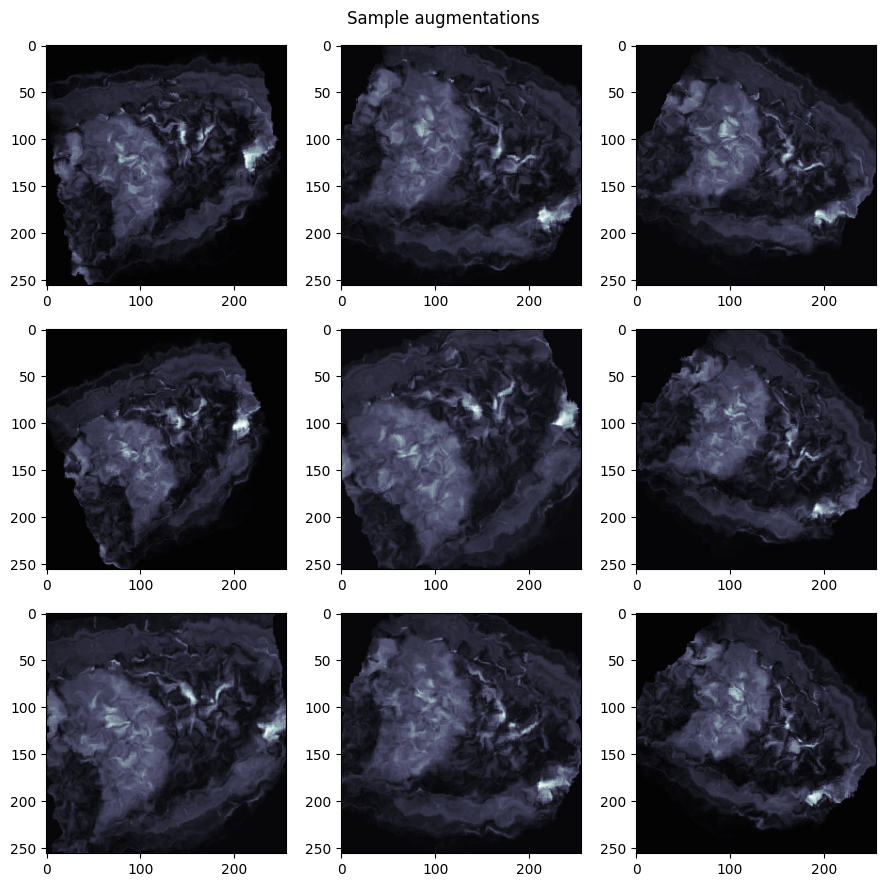

AttributeError: 'NoneType' object has no attribute 'remove_callback'

In [28]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        slice, mask = dataset[1]
        mask_ = np.ma.masked_where(mask == 0, mask)
        axis[i][j].imshow(slice[0], cmap="bone")
        axis[i][j].imshow(mask_[0], cmap="autumn")
        # axis[i][j].axis("off")

fig.suptitle("Sample augmentations")
plt.tight_layout()



In [29]:
class DoubleConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.step = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, 3, padding=1),
                                        torch.nn.ReLU(),
                                        torch.nn.Conv2d(out_channels, out_channels, 3, padding=1),
                                        torch.nn.ReLU())

    def forward(self, X):
        return self.step(X)

In [30]:
class UNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = DoubleConv(1, 64)
        self.layer2 = DoubleConv(64, 128)
        self.layer3 = DoubleConv(128, 256)
        self.layer4 = DoubleConv(256, 512)

        self.layer5 = DoubleConv(512+256, 256)
        self.layer6 = DoubleConv(256+128, 128)
        self.layer7 = DoubleConv(128+64, 64)
        self.layer8 = torch.nn.Conv2d(64, 1, 1)

        self.maxpool = torch.nn.MaxPool2d(2)

    def forward(self, x):

        x1 = self.layer1(x)
        x1m = self.maxpool(x1)

        x2 = self.layer2(x1m)
        x2m = self.maxpool(x2)

        x3 = self.layer3(x2m)
        x3m = self.maxpool(x3)

        x4 = self.layer4(x3m)

        x5 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x4)
        x5 = torch.cat([x5, x3], dim=1)
        x5 = self.layer5(x5)

        x6 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x5)
        x6 = torch.cat([x6, x2], dim=1)
        x6 = self.layer6(x6)

        x7 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x6)
        x7 = torch.cat([x7, x1], dim=1)
        x7 = self.layer7(x7)

        ret = self.layer8(x7)
        return ret

In [31]:
model = UNet()

In [32]:
random_input = torch.randn(1, 1, 256, 256)
output = model(random_input)
assert output.shape == torch.Size([1, 1, 256, 256])

In [33]:
!pip install pytorch-lightning

In [34]:
from pathlib import Path

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import imgaug.augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt



In [35]:
seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15),
              rotate=(-45, 45)),
    iaa.ElasticTransformation()
])

In [36]:
# Create the dataset objects
train_path = Path("Preprocessed/train/")
val_path = Path("Preprocessed/val")

train_dataset = CardiacDataset(train_path, seq)
val_dataset = CardiacDataset(val_path, None)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 1931 train images and 340 val images


In [37]:
batch_size = 16
num_workers = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


In [38]:
class DiceLoss(torch.nn.Module):
    """
    class to compute the Dice Loss
    """
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):

        # Flatten label and prediction tensors
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)
        counter = (pred * mask).sum()  # Numerator
        denum = pred.sum() + mask.sum() + 1e-8  # Denominator. Add a small number to prevent NANS
        dice =  (2*counter)/denum
        return 1 - dice


## Full Segmentation Model

We will now combine everything into the full pytorch lightning model

In [39]:
class AtriumSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.model = UNet()

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = DiceLoss()

    def forward(self, data):
        return torch.sigmoid(self.model(data))

    def training_step(self, batch, batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)

        loss = self.loss_fn(pred, mask)

        self.log("Train Dice", loss)

        if batch_idx % 50 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), "Train")

        return loss

    def validation_step(self, batch, batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)

        loss = self.loss_fn(pred, mask)

        self.log("Val Dice", loss)

        if batch_idx % 2 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), "Val")

        return loss

    def log_images(self, mri, pred, mask, name):

        pred = pred > 0.5

        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(mri[0][0], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][0] == 0, mask[0][0])
        axis[0].imshow(mask_, alpha=0.6)

        axis[1].imshow(mri[0][0], cmap="bone")
        mask_ = np.ma.masked_where(pred[0][0] == 0, pred[0][0])
        axis[1].imshow(mask_, alpha=0.6)

        self.logger.experiment.add_figure(name, fig, self.global_step)

    def configure_optimizers(self):
        return [self.optimizer]

In [40]:
# Instanciate the model and set the random seed
torch.manual_seed(0)
model = AtriumSegmentation()

In [41]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Dice',
    save_top_k=10,
    mode='min')

In [42]:
import torch
import pytorch_lightning as pl
print("CUDA available:", torch.cuda.is_available())
print("PyTorch Lightning version:", pl.__version__)


CUDA available: True
PyTorch Lightning version: 2.4.0


In [53]:
trainer = pl.Trainer(
    accelerator='gpu',
    devices="auto",  # This allows automatic GPU detection
    logger=TensorBoardLogger("./logs"),
    log_every_n_steps=1,
    default_root_dir="./weights",
    callbacks=[checkpoint_callback],
    max_epochs=50
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [80]:
# trainer = pl.Trainer(
#     accelerator='auto',  # Auto-detect the available hardware
#     devices="auto",
#     logger=TensorBoardLogger("./logs"),
#     log_every_n_steps=1,
#     default_root_dir="./weights",
#     callbacks=[checkpoint_callback],
#     max_epochs=10
# )


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params | Mode
--------------------------------------------
0 | model   | UNet     | 7.8 M  | eval
1 | loss_fn | DiceLoss | 0      | eval
--------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.127    Total estimated model params size (MB)
0         Modules in train mode
46        Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [47]:
import nibabel as nib
from tqdm.notebook import tqdm
from celluloid import Camera


In [48]:
model = AtriumSegmentation.load_from_checkpoint("/content/logs/lightning_logs/version_0/checkpoints/epoch=4-step=605.ckpt")

In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval();
model.to(device);

In [50]:
preds = []
labels = []

for slice, label in tqdm(val_dataset):
    slice = torch.tensor(slice).to(device).unsqueeze(0)
    with torch.no_grad():
        pred = model(slice)
    preds.append(pred.cpu().numpy())
    labels.append(label)

preds = np.array(preds)
labels = np.array(labels)

  0%|          | 0/340 [00:00<?, ?it/s]

In [51]:
1-model.loss_fn(torch.from_numpy(preds), torch.from_numpy(labels))  # two possibilities

tensor(0.)

In [52]:
dice_score = 1-DiceLoss()(torch.from_numpy(preds), torch.from_numpy(labels).unsqueeze(0).float())
print(f"The Val Dice Score is: {dice_score}")

The Val Dice Score is: 0.0


In [ ]:
subject = Path("Task02_Heart/imagesTs/la_002.nii.gz")
subject_mri = nib.load(subject).get_fdata()

In [ ]:
# Helper functions for normalization and standardization
def normalize(full_volume):
    """
    Z-Normalization of the whole subject
    """
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std
    return normalized

def standardize(normalized_data):
    """
    Standardize the normalized data into the 0-1 range
    """
    standardized_data = (normalized_data - normalized_data.min()) / (normalized_data.max() - normalized_data.min())
    return standardized_data


In [ ]:
subject_mri = subject_mri[32:-32, 32:-32]
standardized_scan = standardize(normalize(subject_mri))

In [ ]:
standardized_scan.shape

In [ ]:
preds = []
for i in range(standardized_scan.shape[-1]):
    slice = standardized_scan[:,:,i]
    with torch.no_grad():
        pred = model(torch.tensor(slice).unsqueeze(0).unsqueeze(0).float().to(device))[0][0]
        pred = pred > 0.5
    preds.append(pred.cpu())

In [ ]:
fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid

for i in range(standardized_scan.shape[-1]):
    plt.imshow(standardized_scan[:,:,i], cmap="bone")
    mask = np.ma.masked_where(preds[i]==0, preds[i])
    plt.imshow(mask, alpha=0.5, cmap="autumn")

    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation




In [ ]:
from IPython.display import HTML
HTML(animation.to_html5_video())  # convert the animation to a video
